In [1]:
import pandas
import numpy as np
import networkx as nx
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plotMapBox(pickupx,pickupy,dropoffx,dropoffy,deltax,deltay,limits=True):
    '''Plot the map of pickups(red) and dropoffs(blue)
    pickup/dropoff-x/y are lists of some sort
    deltax/y = [min,max] of the bounding box
    limits=True constrains the plot limits
    '''
    #Prepare the box simensions
    boxx = [deltax[0],deltax[0],deltax[1],deltax[1],deltax[0]]
    boxy = [deltay[0],deltay[1],deltay[1],deltay[0],deltay[0]]
    #Establish the figure
    fig=plt.figure(figsize=(8, 8)) #Change this to increase or decrease the size of the figures
    plt.axis('equal')
    #Plot the points
    plt.plot(pickupx,pickupy,color='b',marker=',',lw=0, linestyle="")
    plt.plot(dropoffx,dropoffy,color='r',marker=',',lw=0, linestyle="")
    plt.plot(boxx,boxy,'k')
    if limits==True:
        #Determine the boarder width
        borderx = 0.125*abs(deltax[0]-deltax[1])
        bordery = 0.125*abs(deltay[0]-deltay[1])
        #Set the limits
        plt.xlim([deltax[0]-borderx,deltax[1]+borderx])
        plt.ylim([deltay[0]-bordery,deltay[1]+bordery])

In [3]:
df = pandas.read_csv('rushhr_xy.csv')

#Establish the spacing
xSpacing = 0.3
ySpacing = 0.3

#Add the pickup and dropoff nodes on the grid
df['pickup_grid'] = [(int(round(x/xSpacing)),int(round(y/ySpacing))) for x,y in zip(df['pickup_x'],df['pickup_y'])]
df['dropoff_grid'] = [(int(round(x/xSpacing)),int(round(y/ySpacing))) for x,y in zip(df['dropoff_x'],df['dropoff_y'])]

print('Number of Trips',len(df),'Times 2',len(df)*2)

#Find the max x and y for establishing the matrix
maxx = int(round( max([max(df['pickup_x']),max(df['dropoff_x'])]) / xSpacing ))
maxy = int(round( max([max(df['pickup_y']),max(df['dropoff_y'])]) / ySpacing ))
print(maxx,maxy)

#Make a graph of all the edges, must be a multigraph
H = nx.from_pandas_dataframe(df,'pickup_grid','dropoff_grid',
                             create_using=nx.MultiDiGraph())

print('MultiGraph',nx.to_pandas_dataframe(H).sum().sum())

#Convert to undirected graph
# create weighted graph from H
G = nx.Graph()
for u,v,data in H.edges_iter(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if G.has_edge(u,v):
        G[u][v]['weight'] += w
    else:
        G.add_edge(u, v, weight=w)

print('Graph',nx.to_pandas_dataframe(G).sum().sum())

('Number of Trips', 70963, 'Times 2', 141926)
(13, 48)
('MultiGraph', 70963.0)
('Graph', 141432.0)


In [4]:
#Plot the graph
def plotGraph(G):
    '''
    Plot a graph where the positions of the nodes are specified
    in the name of the node, aka a tuple (x,y) is the node name'''
    pos = {node:node for node in G.nodes()}
    px = [p[0] for p in pos]
    py = [p[1] for p in pos]
    edges = G.edges()
    weights = [G[u][v]['weight']/400.0 for u,v in edges] #divide by 4 for scale in graphing
    sizes = G.degree().values()
    sizes = [s/6 if s/6>7 else 7 for s in sizes]
    
    fig=plt.figure(figsize=(8, 16))
    plt.axis('equal')
    nx.draw(G, pos, edges=edges, width=weights, node_size=sizes)
    #nx.draw_networkx_labels(G,pos)
    plt.show()

('K num nodes', 554)
('K num nodes after removed', 554)
('K num edges', 27506)
('K num edges after removed', 2629)


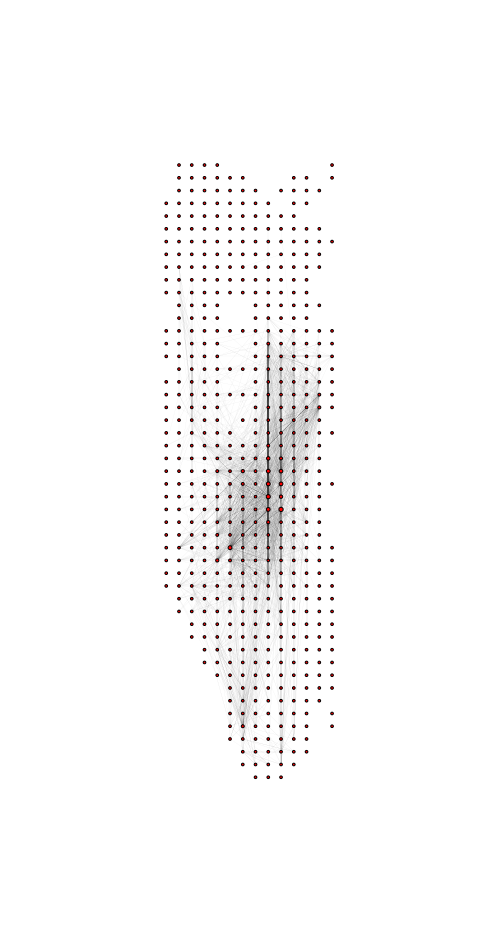

In [6]:
#Threshold the graph's nodes
K=G
print('K num nodes',len(K.nodes()))
K.remove_nodes_from([node for node in K.nodes() \
                     if K.degree(node)<=0])
print('K num nodes after removed',len(K.nodes()))

#Threshold the graph's edges
K = copy.deepcopy(G)
print('K num edges',len(K.edges()))
K.remove_edges_from([edge for edge in K.edges(data=True) \
                     if edge[2]['weight']<=5])
print('K num edges after removed',len(K.edges()))

plotGraph(K)